In [1]:
%pip install torch matplotlib numpy tqdm

In [56]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
from zipfile import ZipFile

def load_ptb_data(root_dir, which):
    """
    Arguments:
        root_dir (string): Directory containing the data files.
        which (string): "train", "test", or "val" dataset
    """
    d = {"train": 1, "test": 5, "val": 7}
    with ZipFile(root_dir, "r") as zip_ref:
        file_name = zip_ref.namelist()[d[which]]
        with zip_ref.open(file_name) as file:
            words = []
            for line in file:
                words += line.decode("utf-8").split(" ")
                words += ["<eos>"]
            if which == "train":
              global word_to_index
              word_to_index = {word: idx for idx, word in enumerate(set(words))}
              global index_to_word
              index_to_word = {idx: word for idx, word in enumerate(set(words))}
            data = np.array([word_to_index[word] for word in words], dtype=np.int32)
            return data


train_set = load_ptb_data(root_dir="./drive/MyDrive/Colab Notebooks/ptb_data.zip", which="train")
test_set = load_ptb_data(root_dir="./drive/MyDrive/Colab Notebooks/ptb_data.zip", which="test")
val_set = load_ptb_data(root_dir="./drive/MyDrive/Colab Notebooks/ptb_data.zip", which="val")

x = val_set[:20]
[index_to_word[i] for i in x]

['',
 'consumers',
 'may',
 'want',
 'to',
 'move',
 'their',
 'telephones',
 'a',
 'little',
 'closer',
 'to',
 'the',
 'tv',
 'set',
 '\n',
 '<eos>',
 '',
 '<unk>',
 '<unk>']

In [73]:
assert (len(index_to_word)) == (max(train_set)+1) == (max(val_set)+1)

In [74]:
from tqdm.notebook import tqdm
import math

hidden_dim = 200
seq_len = 20
batch_size = 20

def initialize_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.uniform_(param, -0.1, 0.1)
        elif "bias" in name:
            nn.init.zeros_(param)


def train(model, train_set, val_set, loss_fn, optimizer, epochs=15, gru=False):
    # initialize_weights(model)

    perplexities = []
    test_perplexities = []

    try:
        # move data to GPU
        train_set = torch.tensor(train_set).to(device)
        val_set = torch.tensor(val_set).to(device)

        for epoch in tqdm(range(epochs)):
            print(f"Epoch: {epoch}")

            if epoch > 4:
                # reduce learning rate
                for g in optimizer.param_groups:
                    g["lr"] *= 0.5

            model.train()
            train_loss = train_epoch(model, train_set, loss_fn, optimizer, gru)
            train_perplexity = math.exp(train_loss)
            perplexities.append(train_perplexity)
            print(f"Train Perplexity: {train_perplexity:.4f}")

            model.eval()
            val_loss = evaluate(model, val_set, loss_fn, gru)
            val_perplexity = math.exp(val_loss)
            test_perplexities.append(val_perplexity)
            print(f"Val Perplexity: {val_perplexity:.4f}")

    except KeyboardInterrupt:
        print("Exiting...")

    return perplexities, test_perplexities

def train_epoch(model, dataset, loss_fn, optimizer, gru):
    total_loss = 0
    count = 0
    data_ptr = 0

    hn = torch.zeros((2, batch_size, hidden_dim)).to(device)
    if not gru:
        cn = torch.zeros((2, batch_size, hidden_dim)).to(device)

    while data_ptr + seq_len * batch_size + 1 <= len(dataset):
        optimizer.zero_grad()

        data_chunk = dataset[data_ptr:data_ptr + seq_len*batch_size].reshape((batch_size, seq_len))
        target = dataset[data_ptr+1:data_ptr+1+seq_len*batch_size].reshape((batch_size, seq_len))

        if gru:
            outputs, hn = model(data_chunk, hn.detach())
        else:
            outputs, (hn, cn) = model(data_chunk, (hn.detach(), cn.detach()))
        loss = loss_fn(outputs.transpose(1, 2), target.long())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item()
        count += 1
        data_ptr += seq_len * batch_size

    return total_loss / count

def evaluate(model, dataset, loss_fn, gru):
    total_loss = 0
    count = 0
    data_ptr = 0

    hn = torch.zeros((2, batch_size, hidden_dim)).to(device)
    if not gru:
        cn = torch.zeros((2, batch_size, hidden_dim)).to(device)

    with torch.no_grad():
        while data_ptr + seq_len * batch_size + 1 <= len(dataset):
            data_chunk = dataset[data_ptr:data_ptr + seq_len*batch_size].reshape((batch_size, seq_len))
            target = dataset[data_ptr+1:data_ptr+1+seq_len*batch_size].reshape((batch_size, seq_len))

            if gru:
                outputs, hn = model(data_chunk, hn.detach())
            else:
                outputs, (hn, cn) = model(data_chunk, (hn, cn))
            loss = loss_fn(outputs.transpose(1, 2), target.long())

            total_loss += loss.item()
            count += 1
            data_ptr += seq_len * batch_size

    return total_loss / count

In [75]:
def test(model, test_set, loss_fn, gru=False):
    total_loss = 0
    count = 0
    data_ptr = 0

    model.eval()

    test_set = torch.tensor(test_set).to(device)

    with torch.no_grad():
        hn = torch.zeros((2, batch_size, hidden_dim)).to(device)
        if not gru:
            cn = torch.zeros((2, batch_size, hidden_dim)).to(device)

        while data_ptr + seq_len * batch_size + 1 <= len(test_set):
            data_chunk = test_set[data_ptr:data_ptr + seq_len*batch_size].reshape((batch_size, seq_len))
            target = test_set[data_ptr+1:data_ptr+1+seq_len*batch_size].reshape((batch_size, seq_len))

            if gru:
                outputs, hn = model(data_chunk, hn.detach())
            else:
                outputs, (hn, cn) = model(data_chunk, (hn.detach(), cn.detach()))
            total_loss += loss_fn(outputs.transpose(1, 2), target.long())

            count += 1
            data_ptr += seq_len*batch_size

        test_perplexity = math.exp(total_loss / count)
        print(f"Test Perplexity: {test_perplexity:.4}")


In [76]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, (hn, cn) = self.lstm(embeds, hidden_state)
        out = self.linear(out)
        return out, (hn, cn)


In [82]:
net = LSTM(200, 200, len(index_to_word))
net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=2)
# perplexities, test_perplexities = train(net, train_set, test_set, loss_fn, optimizer)
perplexities, test_perplexities = train(net, train_set, val_set, loss_fn, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 247.1724
Val Perplexity: 161.2729
Epoch: 1
Train Perplexity: 139.9072
Val Perplexity: 129.2999
Epoch: 2
Train Perplexity: 111.7529
Val Perplexity: 116.7965
Epoch: 3
Train Perplexity: 96.0678
Val Perplexity: 110.6425
Epoch: 4
Train Perplexity: 85.5375
Val Perplexity: 107.6625
Epoch: 5
Train Perplexity: 73.4383
Val Perplexity: 103.0982
Epoch: 6
Train Perplexity: 66.8529
Val Perplexity: 100.7571
Epoch: 7
Train Perplexity: 63.3627
Val Perplexity: 99.5007
Epoch: 8
Train Perplexity: 61.4914
Val Perplexity: 98.7950
Epoch: 9
Train Perplexity: 60.4766
Val Perplexity: 98.4281
Epoch: 10
Train Perplexity: 59.9178
Val Perplexity: 98.2611
Epoch: 11
Train Perplexity: 59.6087
Val Perplexity: 98.1735
Epoch: 12
Train Perplexity: 59.4401
Val Perplexity: 98.1233
Epoch: 13
Train Perplexity: 59.3500
Val Perplexity: 98.0991
Epoch: 14
Train Perplexity: 59.3031
Val Perplexity: 98.0889


In [78]:
test(net, test_set, loss_fn)

Test Perplexity: 98.32


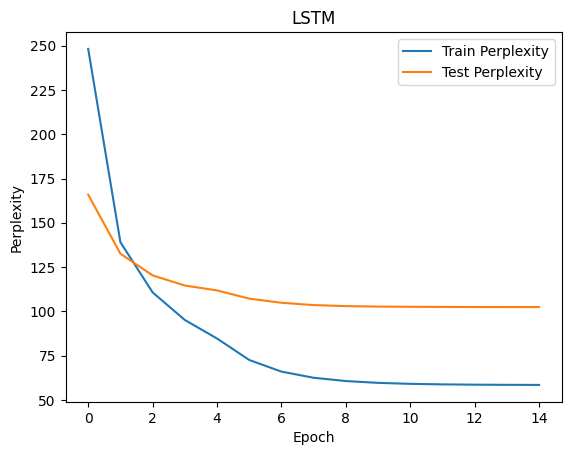

In [79]:
plt.plot(perplexities, label="Train Perplexity")
plt.plot(test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("LSTM")
plt.legend()
plt.show()

In [83]:
class DropoutLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.25)
        self.drouput = nn.Dropout(0.25)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, (hn, cn) = self.lstm(embeds, hidden_state)
        out = self.drouput(out)
        out = self.linear(out)
        return out, (hn, cn)

In [87]:
dropout_net = DropoutLSTM(200, 200, len(index_to_word))
dropout_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dropout_net.parameters(), lr=2)
dropout_perplexities, dropout_test_perplexities = train(dropout_net, train_set, val_set, loss_fn, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 264.5036
Val Perplexity: 173.2500
Epoch: 1
Train Perplexity: 160.7590
Val Perplexity: 140.2869
Epoch: 2
Train Perplexity: 134.1920
Val Perplexity: 124.9876
Epoch: 3
Train Perplexity: 119.5195
Val Perplexity: 116.3908
Epoch: 4
Train Perplexity: 109.8365
Val Perplexity: 110.7141
Epoch: 5
Train Perplexity: 99.1968
Val Perplexity: 104.5837
Epoch: 6
Train Perplexity: 93.5240
Val Perplexity: 101.5564
Epoch: 7
Train Perplexity: 90.5755
Val Perplexity: 100.1579
Epoch: 8
Train Perplexity: 89.0205
Val Perplexity: 99.5464
Epoch: 9
Train Perplexity: 88.1961
Val Perplexity: 99.3206
Epoch: 10
Train Perplexity: 87.8403
Val Perplexity: 99.1966
Epoch: 11
Train Perplexity: 87.5838
Val Perplexity: 99.1375
Epoch: 12
Train Perplexity: 87.3869
Val Perplexity: 99.1114
Epoch: 13
Train Perplexity: 87.4298
Val Perplexity: 99.1019
Epoch: 14
Train Perplexity: 87.2895
Val Perplexity: 99.0960


In [97]:
test(dropout_net, test_set, loss_fn)

Test Perplexity: 95.43


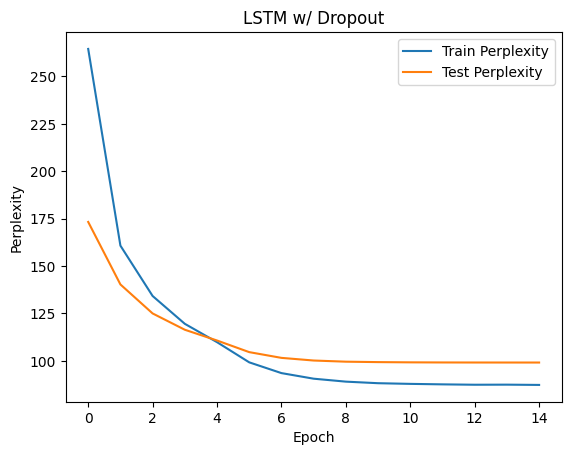

In [89]:
plt.plot(dropout_perplexities, label="Train Perplexity")
plt.plot(dropout_test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("LSTM w/ Dropout")
plt.legend()
plt.show()

In [68]:
class GRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, hn = self.gru(embeds, hidden_state)
        out = self.linear(out)
        return out, hn


In [94]:
gru_net = GRU(200, 200, len(index_to_word))
gru_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gru_net.parameters(), lr=1)
gru_perplexities, gru_test_perplexities = train(gru_net, train_set, val_set, loss_fn, optimizer, gru=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 217.0973
Val Perplexity: 155.4574
Epoch: 1
Train Perplexity: 129.8318
Val Perplexity: 130.9172
Epoch: 2
Train Perplexity: 105.7735
Val Perplexity: 121.6677
Epoch: 3
Train Perplexity: 91.9848
Val Perplexity: 117.8273
Epoch: 4
Train Perplexity: 82.4945
Val Perplexity: 116.5055
Epoch: 5
Train Perplexity: 70.6923
Val Perplexity: 110.6701
Epoch: 6
Train Perplexity: 64.6428
Val Perplexity: 107.9467
Epoch: 7
Train Perplexity: 61.4725
Val Perplexity: 106.6747
Epoch: 8
Train Perplexity: 59.7586
Val Perplexity: 106.1862
Epoch: 9
Train Perplexity: 58.8185
Val Perplexity: 105.9996
Epoch: 10
Train Perplexity: 58.3054
Val Perplexity: 105.9183
Epoch: 11
Train Perplexity: 58.0297
Val Perplexity: 105.8829
Epoch: 12
Train Perplexity: 57.8844
Val Perplexity: 105.8709
Epoch: 13
Train Perplexity: 57.8092
Val Perplexity: 105.8679
Epoch: 14
Train Perplexity: 57.7708
Val Perplexity: 105.8677


In [96]:
test(gru_net, test_set, loss_fn, gru=True)

Test Perplexity: 100.9


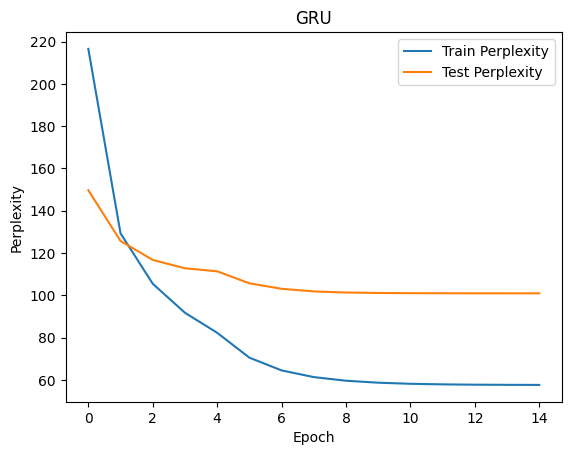

In [90]:
plt.plot(gru_perplexities, label="Train Perplexity")
plt.plot(gru_test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("GRU")
plt.legend()
plt.show()

In [70]:
class DropoutGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.25)
        self.dropout = nn.Dropout(0.25)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, hn = self.gru(embeds, hidden_state)
        out = self.dropout(out)
        out = self.linear(out)
        return out, hn


In [93]:
dropout_gru_net = DropoutGRU(200, 200, len(index_to_word))
dropout_gru_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dropout_gru_net.parameters(), lr=1)
dropout_gru_perplexities, dropout_gru_test_perplexities = train(dropout_gru_net, train_set, val_set, loss_fn, optimizer, gru=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 243.4700
Val Perplexity: 163.6269
Epoch: 1
Train Perplexity: 155.6697
Val Perplexity: 137.5199
Epoch: 2
Train Perplexity: 132.9456
Val Perplexity: 125.6158
Epoch: 3
Train Perplexity: 120.3619
Val Perplexity: 118.9888
Epoch: 4
Train Perplexity: 111.8226
Val Perplexity: 114.5037
Epoch: 5
Train Perplexity: 100.7222
Val Perplexity: 107.7897
Epoch: 6
Train Perplexity: 94.8848
Val Perplexity: 104.6023
Epoch: 7
Train Perplexity: 91.8090
Val Perplexity: 103.2140
Epoch: 8
Train Perplexity: 90.2466
Val Perplexity: 102.6703
Epoch: 9
Train Perplexity: 89.4131
Val Perplexity: 102.3920
Epoch: 10
Train Perplexity: 88.9681
Val Perplexity: 102.2919
Epoch: 11
Train Perplexity: 88.9013
Val Perplexity: 102.2464
Epoch: 12
Train Perplexity: 88.7191
Val Perplexity: 102.2206
Epoch: 13
Train Perplexity: 88.5644
Val Perplexity: 102.2060
Epoch: 14
Train Perplexity: 88.5632
Val Perplexity: 102.1978


In [95]:
test(dropout_gru_net, test_set, loss_fn, gru=True)

Test Perplexity: 98.29


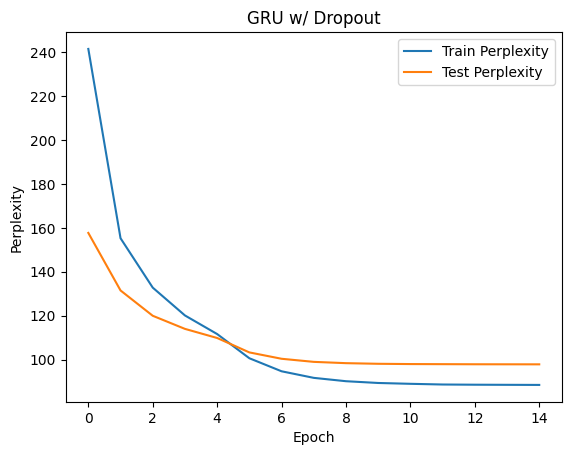

In [92]:
plt.plot(dropout_gru_perplexities, label="Train Perplexity")
plt.plot(dropout_gru_test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("GRU w/ Dropout")
plt.legend()
plt.show()